In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import AalenAdditiveFitter
import patsy
import emoji



%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [50]:
ses_full = pd.read_csv("../data/ses_full.csv")
ses_1_42 = pd.read_csv("../data/ses_1_42.csv")
students = pd.read_csv("../data/students.csv")
msg = pd.read_csv("../data/msg.csv")


In [21]:
ses_1_42['timestamp_clean'] = pd.to_datetime(ses_1_42.timestamp_clean, format='%Y-%m-%d %H:%M:%S', errors='ignore')
students['first_session'] = pd.to_datetime(students['first_session'], format='%Y-%m-%d %H:%M:%S', errors='ignore')

# Exploratory Data Analysis: Session, Message and Student Data

## Session

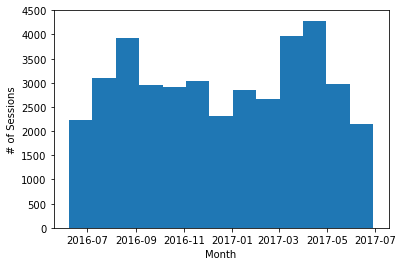

In [9]:
plt.hist(ses_1_42.timestamp_clean.values, bins =13)
plt.xlabel('Month')
plt.ylabel('# of Sessions')

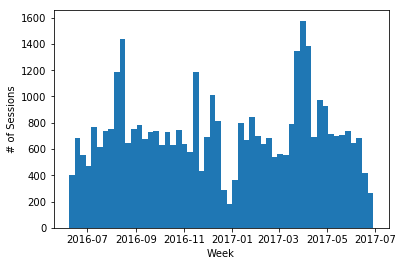

In [10]:
plt.hist(ses_1_42.timestamp_clean.values, bins = 54)
plt.xlabel('Week')
plt.ylabel('# of Sessions')

* Two Largest peaks in number of sessions are the begining and end of the 2016-2017 school year.
* The lowest point is in December.
* Looking at number of sessions by week below, there are some isolated drops around thanksgiving and Christmas.

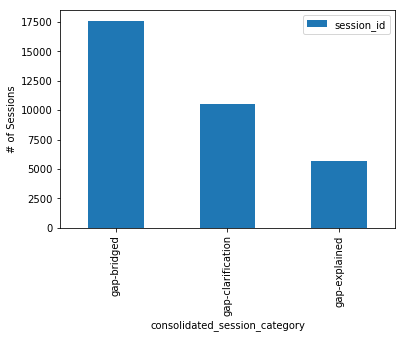

In [11]:
## Learning outcomes
learning_outcome_counts = pd.DataFrame(ses_1_42.groupby('consolidated_session_category').count()['session_id'])
learning_outcome_counts.plot(kind='bar')
plt.ylabel('# of Sessions')






* We see that the majority class, ~45% of graded sessions, is "gap-bridged"(the successful learning outcome). "gap-explained"(moderate success) and "gap-clarification"(minimal success)
* This means our overall learning success rate of 52%

In [19]:
monthly_all = pd.DataFrame(ses_1_42.groupby('year-month').count()['session_id']).reset_index()
monthly_gb = pd.DataFrame(ses_1_42[ses_1_42.consolidated_session_category == "gap-bridged"].groupby('year-month').count()['session_id']).reset_index()
monthly_all = monthly_all.merge(monthly_gb, on = 'year-month')
monthly_all['gb_rate'] = 1.0* monthly_all.session_id_y /monthly_all.session_id_x 
monthly_all = monthly_all.set_index('year-month')

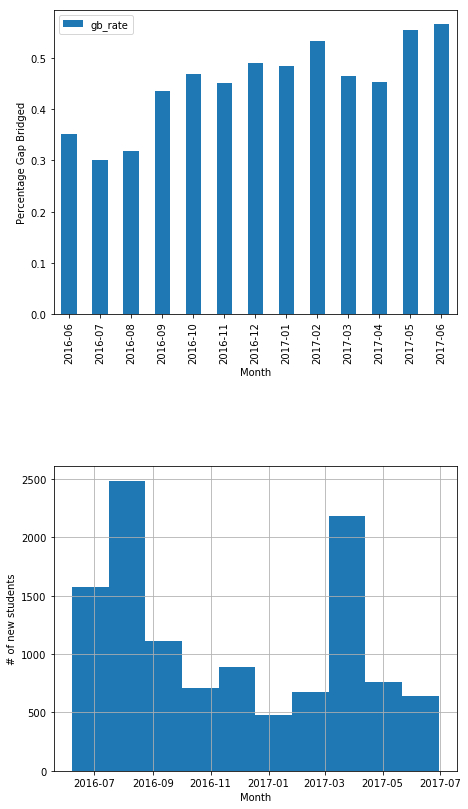

In [22]:
fig = plt.figure(figsize= (8,14))

ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

monthly_all.drop(['session_id_y', 'session_id_x'], axis = 1).plot(kind='bar', ax = ax1)
ax1.set_xlabel('Month')
ax1.set_ylabel('Percentage Gap Bridged')


students.first_session.hist( ax = ax2)
ax2.set_xlabel('Month')
ax2.set_ylabel('# of new students')

plt.subplots_adjust(hspace=0.5, left=0.2)

* We see a matching effect with new students and drops in gb rate, particularily in August.
    * This suggests some type of interaction between time since first session and gap bridged student performance

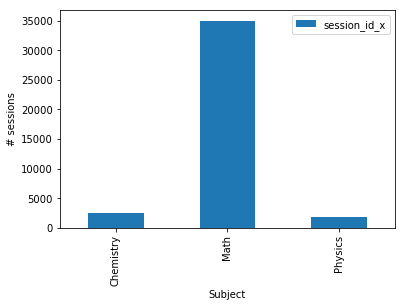

In [23]:
subject_all = pd.DataFrame(ses_1_42.groupby('subject').count()['session_id']).reset_index()
subject_gb = pd.DataFrame(ses_1_42[ses_1_42.consolidated_session_category == "gap-bridged"].groupby('subject').count()['session_id']).reset_index()
subject_all = subject_all.merge(subject_gb, on = 'subject')
subject_all['gb_rate'] = 1.0* subject_all.session_id_y /subject_all.session_id_x 

subject_all.set_index('subject').drop(['gb_rate', 'session_id_y'], axis = 1).plot(kind='bar')
plt.xlabel('Subject')
plt.ylabel('# sessions')

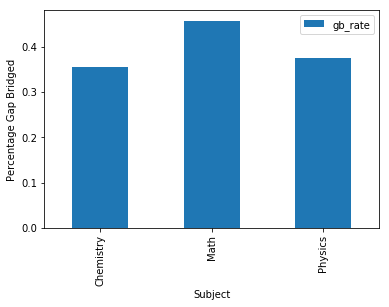

In [24]:
subject_all.set_index('subject').drop(['session_id_y', 'session_id_x'], axis = 1).plot(kind='bar')
plt.xlabel('Subject')
plt.ylabel('Percentage Gap Bridged')

* ~88% Math sessions
* Math has a gap bridged rate 10% higher than Chemistry and 8% higher than Physics.
    * This indicates that there may be aspects of science problems that are harder to solve than Math problems.

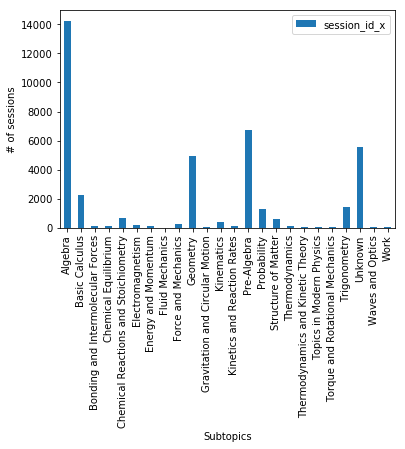

In [25]:
subtopic_all = pd.DataFrame(ses_1_42.groupby('subtopic').count()['session_id']).reset_index()
subtopic_gb = pd.DataFrame(ses_1_42[ses_1_42.consolidated_session_category == "gap-bridged"].groupby('subtopic').count()['session_id']).reset_index()
subtopic_all = subtopic_all.merge(subtopic_gb, on = 'subtopic')
subtopic_all['gb_rate'] = 1.0* subtopic_all.session_id_y /subtopic_all.session_id_x 

subtopic_all.set_index('subtopic').drop(['session_id_y', 'gb_rate'], axis = 1).plot(kind='bar')
plt.xlabel('Subtopics')
plt.ylabel('# of sessions')

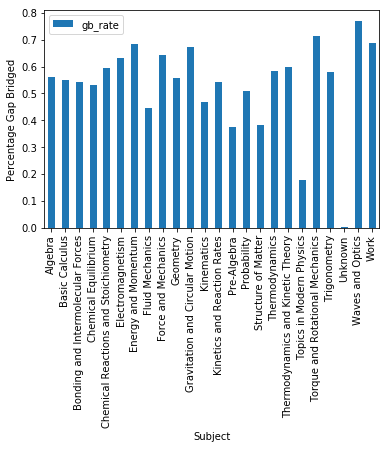

In [133]:
subtopic_all.set_index('subtopic').drop(['session_id_y', 'session_id_x'], axis = 1).plot(kind='bar')
plt.xlabel('Subject')
plt.ylabel('Percentage Gap Bridged')

* Much like subject, subtopic is heavily weighted towards Math related areas of the study in terms of overall counts.
* The clear top 3 are Algebra, Pre-Algebra and Geometry.
* Interestingly Pre-Algebra has a gap bridged rate 19% less than Alegebra, 56% versus 37% respectively.
    * Possible indication of a steep learning curve. 

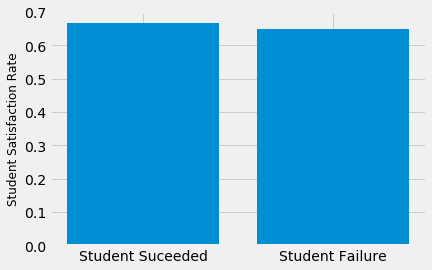

In [29]:
sc_by_gb_bool = [1 - ses_full[ses_full.gb_bool == 1].student_complained.mean(), 1 - ses_full[ses_full.gb_bool == 0].student_complained.mean()]
sc_labels = [0, 1]#
ses_full['cnt'] = 1
plt.style.use('fivethirtyeight')

plt.bar(pd.Series(sc_labels), pd.Series(sc_by_gb_bool) )
plt.xticks([0, 1], ('Student Suceeded', 'Student Failure'))
#plt.xlabel('')
plt.ylabel('Student Satisfaction Rate', size = 12)

* Rates of student satifaction are very similar for students that solve their problem as they are in sessions where the problem is not solved.
    * This suggests there may be a disconnect between teaching methods and student needs.
    

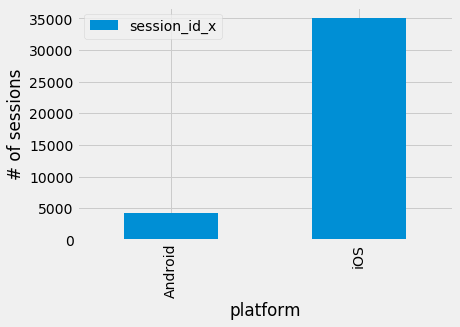

In [30]:
student_platform_all = pd.DataFrame(ses_1_42.groupby('student_platform').count()['session_id']).reset_index()
student_platform_gb = pd.DataFrame(ses_1_42[ses_1_42.consolidated_session_category == "gap-bridged"].groupby('student_platform').count()['session_id']).reset_index()
student_platform_all = student_platform_all.merge(student_platform_gb, on = 'student_platform')
student_platform_all['gb_rate'] = 1.0* student_platform_all.session_id_y /student_platform_all.session_id_x 

student_platform_all.set_index('student_platform').drop(['session_id_y', 'gb_rate'], axis = 1).plot(kind='bar')
plt.xlabel('platform')
plt.ylabel('# of sessions')

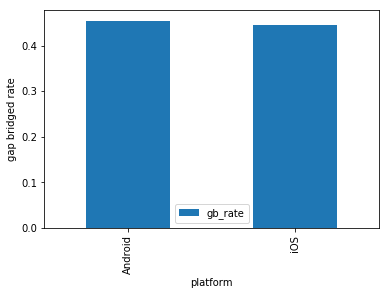

In [146]:
student_platform_all.set_index('student_platform').drop(['session_id_y', 'session_id_x'], axis = 1).plot(kind='bar')
plt.xlabel('platform')
plt.ylabel('gap bridged rate')

* ~88% iOS
* Only 0.8% difference in gap bridged rate
* This shows there's unlikely to be a need to diffferentiate between the two categories when modelling.

## Students

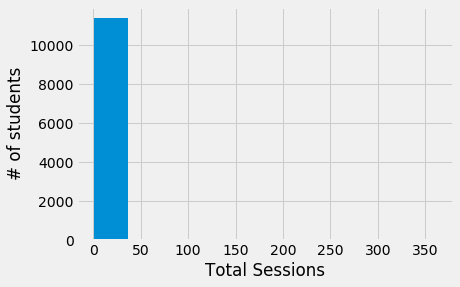

In [31]:
students.session_count.hist()
plt.xlabel("Total Sessions")
plt.ylabel("# of students")


* Almost all students have participated in less than 40 sessions.

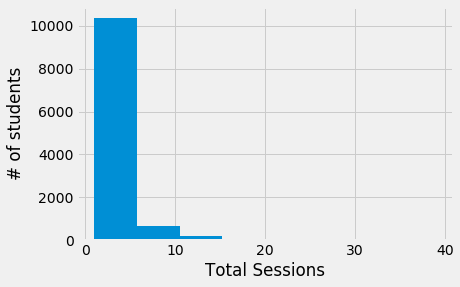

In [32]:

students[students.session_count< 40].session_count.hist(bins = 8)
plt.xlabel("Total Sessions")
plt.ylabel("# of students")

* Of these students with 40 or less sessions there remains a large cluster with 5 or less sessions.

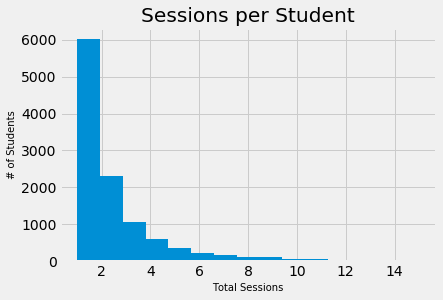

In [38]:
# New Transformations
ses_1_42 = ses_1_42.merge(students, on = 'student_id')
ses_1_42.loc[ses_1_42.consolidated_session_category == "gap-bridged", 'gb_bool'] = 1
ses_1_42.loc[ses_1_42.consolidated_session_category != "gap-bridged", 'gb_bool'] = 0
#ses_1_42['days_since_ses_1'] = (ses_1_42.timestamp_clean - ses_1_42.first_session ).astype('timedelta64[D]')

students[(students.session_count<=15)].session_count.hist(bins = 15)
plt.xlabel("Total Sessions", size =10)
plt.ylabel("# of Students", size =10)
plt.title("Sessions per Student")

* Here's a view looking at students with less than 16 sessions. 
* One can see that subseting on number of sessions would create a lot of data loss.

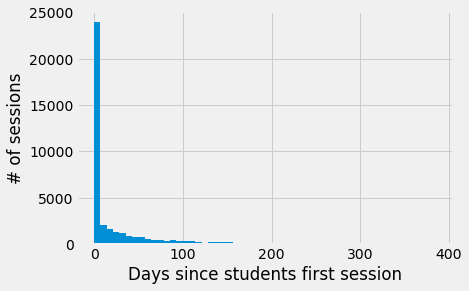

In [40]:
ses_1_42.days_since_ses_1.hist(bins = 54)
plt.xlabel("Days since students first session")
plt.ylabel("# of sessions")



* This shows that the vast majority of users do not use over  a long period of time most students will complete all their sessions within the space of a few days.

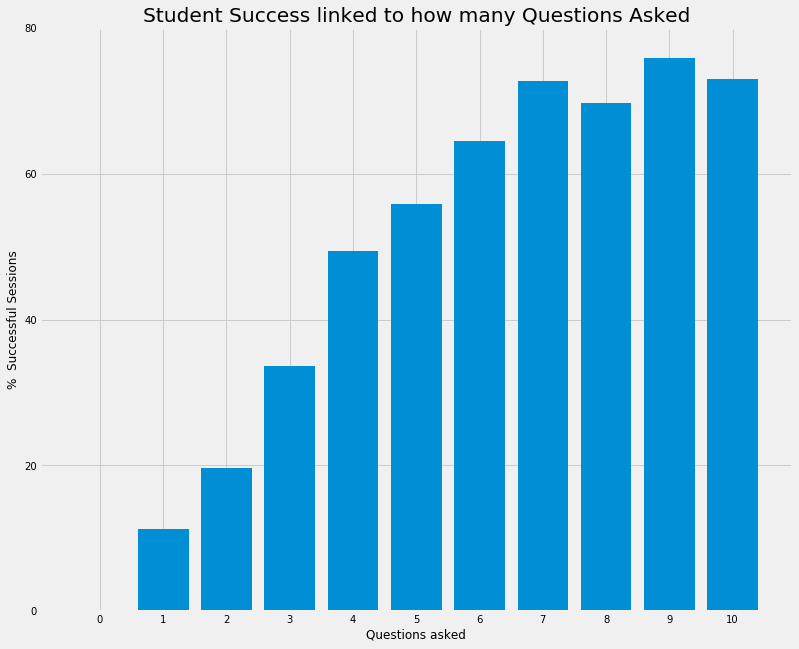

In [42]:
# gb rate per question asked
gb_rate_by_question_number = ses_full[ses_full.ses_num_order==1].groupby('question_student_count')['gb_bool'].mean()
avg_session_count_by_question_number = ses_full[ses_full.ses_num_order==1].groupby('question_student_count')['session_count'].mean()

x = gb_rate_by_question_number.index[:11]
y = [y*100 for y in gb_rate_by_question_number.values[:11]]
c = avg_session_count_by_question_number[:12]
plt.figure(figsize = (12,10))
plt.bar(x,y)
plt.title("Student Success linked to how many Questions Asked")
plt.ylabel('%  Successful Sessions', size = 12)
plt.xlabel('Questions asked', size = 12)
plt.xticks(np.arange(min(x), max(x)+1, 1.0), size = 10)
plt.yticks(np.arange(0, 100, 20), size = 10)
plt.style.use('fivethirtyeight')

#plt.savefig('images/blogplot1.png', bbox_inches = 'tight')

* When students participate in learning, they have successful outcomes in their session.
    * Looking at the first 10 questions, each question asked by the student results in a 7.2% rise in success rate on that session
    * We also see this trend continuing throughout the students other tutoring sessions.
        * Students that ask 5 or more questions in their first session have a lefetime gap bridged rate twice the amount of students that ask less than 5 questions.


(array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 <a list of 8 Text yticklabel objects>)

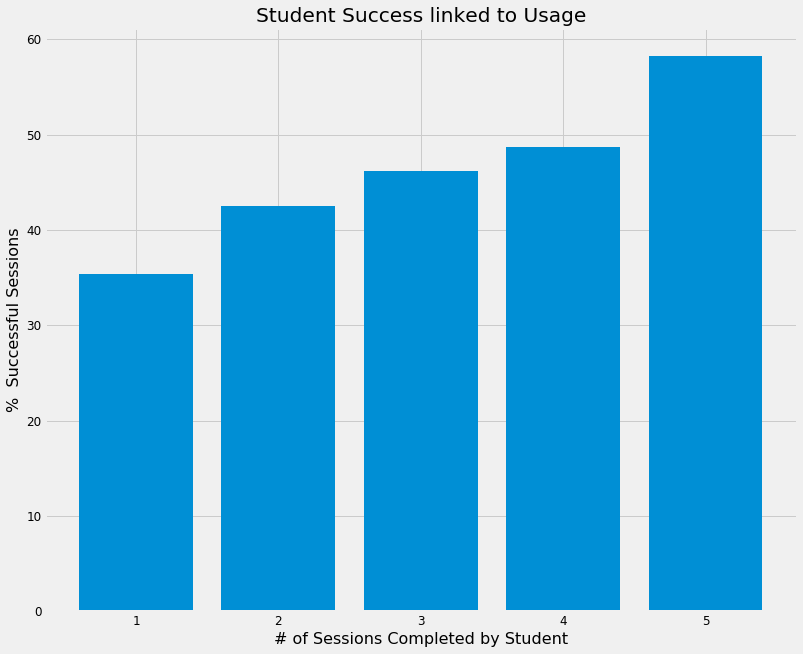

In [45]:
tholds = [0,5,10,15,20,25]
students.loc[(students.session_count > -1) & (students.session_count <= 5), "five_thres"] = 1
students.loc[(students.session_count > 5) & (students.session_count <= 10), "five_thres"] = 2
students.loc[(students.session_count > 10) & (students.session_count <= 15), "five_thres"] = 3
students.loc[(students.session_count > 15) & (students.session_count <= 20), "five_thres"] = 4
students.loc[(students.session_count > 20), "five_thres"] = 5

gb_rate_by_ses_count =  students.groupby("five_thres")['gb_count'].sum() / students.groupby("five_thres")['counter'].sum() 
x = gb_rate_by_ses_count.index
y = gb_rate_by_ses_count.values *100
plt.figure(figsize = (12,10))
plt.bar(x,y)
plt.title("Student Success linked to Usage")
plt.xlabel('# of Sessions Completed by Student', size = 16)
plt.ylabel('%  Successful Sessions', size = 16)
plt.xticks(np.arange(1,6,1), size = 12)
plt.yticks( size = 12)

#plt.savefig('images/blogplot2.png', bbox_inches = 'tight')

* The data suggests that students that complete over 20 sessions show  66% higher success rate than students that only compete 5 or less sessions.
* If the average session is 23 minutes (rough estimate). Than 20 sessions works out to just under 8 hours of work.


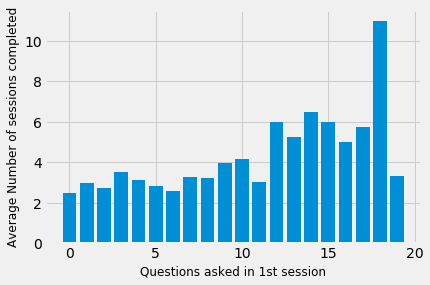

In [46]:
# gb rate per question asked
avg_session_count_by_question_number = ses_full[ses_full.ses_num_order==1 ].groupby('question_student_count')['session_count'].mean()

x = avg_session_count_by_question_number.index[:20]
y = avg_session_count_by_question_number.values[:20]
c = avg_session_count_by_question_number[:20]
plt.bar(x,y)
plt.xlabel('Questions asked in 1st session', size = 12)
plt.ylabel('Average Number of sessions completed', size = 12)
#plt.savefig('images/blogplot2.png', bbox_inches = 'tight')